## AD Channel 

Applied Bell state, U0, Ansatz and training 
Ansatz - Realamplitude 
Optimizer - COBYLA



In [1]:
import numpy as np  
%matplotlib inline
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import time


import matplotlib.pyplot as plt


from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import sqrtm, eig
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import *
from qiskit import *
import numpy as np
import math
from qiskit.quantum_info import concurrence, state_fidelity, average_gate_fidelity, process_fidelity, Statevector
import matplotlib.pyplot as plt
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import sqrtm, eig
from sympy import symbols, sqrt
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
import sympy


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics




algorithm_globals.random_seed = 42

In [2]:
data = pd.read_csv('rtn_dataset.csv')

data['true_label']=data['concurrence'].apply(lambda x: 0 if x == 0 else 1)

In [3]:
data

,time,gamma,concurrence,true_label
0,100.000,0.1,0.000000,0
1,100.100,0.1,0.000000,0
2,100.200,0.1,0.000000,0
3,100.300,0.1,0.000000,0
4,100.400,0.1,0.000000,0
...,...,...,...,...
1995,0.995,0.9,0.725259,1
1996,0.996,0.9,0.724569,1
1997,0.997,0.9,0.723878,1
1998,0.998,0.9,0.723878,1


In [4]:
data_features = data.iloc[:, 0:2]
data_labels = data.iloc[:,3].values

In [5]:
#data_labels

In [6]:
X = data_features
y = data_labels

In [7]:
X

,time,gamma
0,100.000,0.1
1,100.100,0.1
2,100.200,0.1
3,100.300,0.1
4,100.400,0.1
...,...,...
1995,0.995,0.9
1996,0.996,0.9
1997,0.997,0.9
1998,0.998,0.9


In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time', y='true_label', hue='true_label', palette='viridis', data=data)
plt.title('Entangles state vs Seperable state')
plt.xlabel('qubit_1')
plt.ylabel('State')
plt.legend(title='Label')
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

In [9]:
num_qubits=X.shape
num_qubits

(2000, 2)

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate


class UHGate(Gate):
    def __init__(self, x,y, label=None):
        super().__init__('U', 2, [x,y], label=label)
        
        
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.unitary_mat_0()[1], [0, 1])

        self.definition = qc

    
    def kraus_list(self,gamma,t):
       
        hf=np.sqrt(((2*0.5)/gamma**2)-1)
        nf=np.exp(-gamma*t)*((np.cos(hf*(gamma*t))+(np.sin(hf*(gamma*t))/hf)))

        k1=[[np.sqrt((1+nf)/2),0],[0,np.sqrt((1+nf)/2)]]
        k2=[[np.sqrt((1-nf)/2),0],[0,-np.sqrt((1-nf)/2)]]
        return k1,k2
    


    def unitary_mat_0(self):
        gamma = self.params[1]
        t = self.params[0]
        k_list=self.kraus_list(gamma,t)
        k0=np.array(k_list[0])
        k1=np.array(k_list[1])

        D0=sqrtm(np.identity(2)-np.matmul(k0.T.conjugate(),k0))
        D0dag=sqrtm(np.identity(2)-np.matmul(k0,k0.T.conjugate()))
        D1=sqrtm(np.identity(2)-np.matmul(k1.T.conjugate(),k1))
        D1dag=sqrtm(np.identity(2)-np.matmul(k1,k1.T.conjugate()))

        z=np.array([[1,0],[0,-1]])
        x=np.array([[0,1],[1,0]])
        y=np.array([[0,-1j],[1j,0]])

        u0= np.kron((x-1j*y)/2,D0)+ np.kron((x+1j*y)/2,D0dag)+np.kron((np.identity(2)+z)/2,k0)-np.kron((np.identity(2)-z)/2,k0.T.conjugate())
        u1= np.kron((x-1j*y)/2,D1)+ np.kron((x+1j*y)/2,D1dag)+np.kron((np.identity(2)+z)/2,k1)-np.kron((np.identity(2)-z)/2,k1.T.conjugate())


        return u0,u1

        
class RTN0(Gate):
    def __init__(self, x,y, label=None):
        super().__init__('RTN0', 2, [x,y], label=label)
        
        
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.unitary_mat_rtn()[0], [0, 1])
       
        self.definition = qc

    
    def kraus_list_rtn(self,gamma,t):
        a=0.5
        gamma = gamma
        hf=np.sqrt(((2*a)/gamma**2)-1)
        nf=np.exp(-gamma*t)*((np.cos(hf*(gamma*t))+(np.sin(hf*(gamma*t))/hf)))
        k1=[[np.sqrt((1+nf)/2),0],[0,np.sqrt((1+nf)/2)]]
        k2=[[np.sqrt((1-nf)/2),0],[0,-np.sqrt((1-nf)/2)]]
        

       
          

        return k1,k2


    def unitary_mat_rtn(self):
        gamma = self.params[0]
        t = self.params[1]
        #print(f'gamma_1-{gamma}, time_1-{t}\n')
        k_list=self.kraus_list_rtn(gamma,t)
        k0=np.array(k_list[0])
        k1=np.array(k_list[1])
        D0=sqrtm(np.identity(2)-np.matmul(k0.T.conjugate(),k0))
        D0dag=sqrtm(np.identity(2)-np.matmul(k0,k0.T.conjugate()))
        D1=sqrtm(np.identity(2)-np.matmul(k1.T.conjugate(),k1))
        D1dag=sqrtm(np.identity(2)-np.matmul(k1,k1.T.conjugate()))

        z=np.array([[1,0],[0,-1]])
        x=np.array([[0,1],[1,0]])
        y=np.array([[0,-1j],[1j,0]])
        
        u0= np.kron((x-1j*y)/2,D0)+ np.kron((x+1j*y)/2,D0dag)+np.kron((np.identity(2)+z)/2,k0)-np.kron((np.identity(2)-z)/2,k0.T.conjugate())
        u1= np.kron((x-1j*y)/2,D1)+ np.kron((x+1j*y)/2,D1dag)+np.kron((np.identity(2)+z)/2,k1)-np.kron((np.identity(2)-z)/2,k1.T.conjugate())


        return u0,u1





class RTN1(Gate):
    def __init__(self, x,y, label=None):
        super().__init__('RTN1', 2, [x,y], label=label)
 
    def _define(self):
        qc = QuantumCircuit(2)
        
        qc.unitary(self.unitary_mat_rtn()[1], [0, 1])
        self.definition = qc

    def kraus_list_rtn(self,t,gamma):
        a=0.51
        gamma = gamma
        hf=np.sqrt(((2*a)/gamma**2)-1)
        nf=np.exp(-gamma*t)*((np.cos(hf*(gamma*t))+(np.sin(hf*(gamma*t))/hf)))
        k1=[[np.sqrt((1+nf)/2),0],[0,np.sqrt((1+nf)/2)]]
        k2=[[np.sqrt((1-nf)/2),0],[0,-np.sqrt((1-nf)/2)]]
     
        return k1,k2


    def unitary_mat_rtn(self):
        gamma = self.params[0]
        t = self.params[1]
        #print(f'gamma_2-{gamma}, time_2-{t}\n')
        k_list=self.kraus_list_rtn(gamma,t)
       
        k0=np.array(k_list[0])
        k1=np.array(k_list[1])
        D0=sqrtm(np.identity(2)-np.matmul(k0.T.conjugate(),k0))
        D0dag=sqrtm(np.identity(2)-np.matmul(k0,k0.T.conjugate()))
        D1=sqrtm(np.identity(2)-np.matmul(k1.T.conjugate(),k1))
        D1dag=sqrtm(np.identity(2)-np.matmul(k1,k1.T.conjugate()))

        z=np.array([[1,0],[0,-1]])
        x=np.array([[0,1],[1,0]])
        y=np.array([[0,-1j],[1j,0]])
        
        u0= np.kron((x-1j*y)/2,D0)+ np.kron((x+1j*y)/2,D0dag)+np.kron((np.identity(2)+z)/2,k0)-np.kron((np.identity(2)-z)/2,k0.T.conjugate())
        u1= np.kron((x-1j*y)/2,D1)+ np.kron((x+1j*y)/2,D1dag)+np.kron((np.identity(2)+z)/2,k1)-np.kron((np.identity(2)-z)/2,k1.T.conjugate())


        return u0,u1



num_qubits = 2
feature_map=QuantumCircuit(2)
feature_map.h(0)
feature_map.cx(0,1)
x,y = Parameter('x'),Parameter('y')
mat = UHGate(x,y)
# x[0], x[1] = symbols('t gamma')
#  x[0],x[1] = symbols('x[0] x[1]')
feature_map.append(RTN1(x,y),[0,1])
feature_map.draw()



┌───┐     ┌────────────┐
q_0: ┤ H ├──■──┤0           ├
     └───┘┌─┴─┐│  Rtn1(x,y) │
q_1: ─────┤ X ├┤1           ├
          └───┘└────────────┘

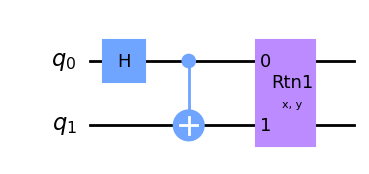

In [11]:
feature_map.draw(output='mpl',style="clifford")

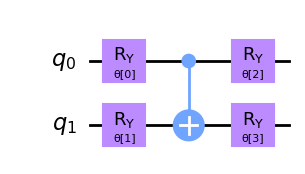

In [12]:
from qiskit.circuit.library import RealAmplitudes,EfficientSU2,NLocal,TwoLocal
from qiskit.circuit.library import NLocal, CXGate, CRZGate, RXGate
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

ansatz = RealAmplitudes(num_qubits=2, reps=1)
ansatz.decompose().draw(output="mpl", style="clifford", fold=50)
 
  

In [13]:
model=QuantumCircuit(2)
model.append(feature_map,[0,1])
model.append(ansatz,[0,1])

# model.decompose().decompose().draw("mpl", style="clifford")

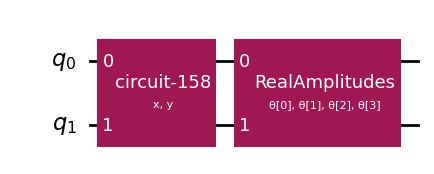

In [14]:
model.draw('mpl')

In [15]:
from qiskit.quantum_info import SparsePauliOp
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])


In [16]:
from qiskit_algorithms.optimizers import COBYLA,AQGD,SPSA

optimizer = COBYLA(maxiter=100)
from qiskit.primitives import Sampler

sampler = Sampler()
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (6, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    #print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")


def callback_graph_2(weights, obj_func_eval):
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

In [17]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42

train_features, val_features, train_labels, val_labels = train_test_split(
    data_features, data_labels, test_size=0.2, random_state=42
)


In [18]:
from sklearn.metrics import log_loss
num_epochs = 1
train_losses = []
val_losses = []

def compute_loss(predictions, labels):
    return log_loss(labels, predictions)


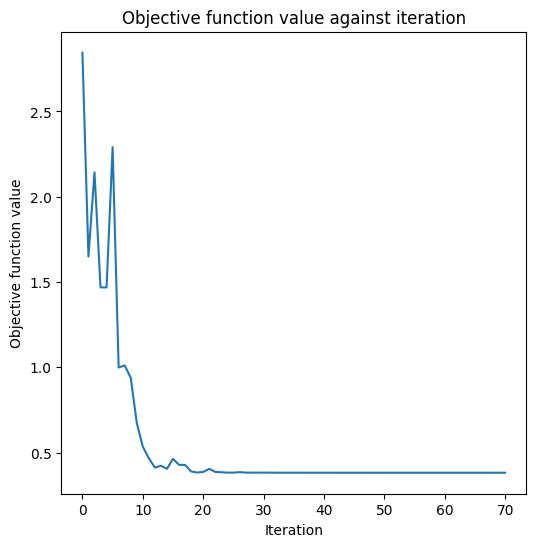

In [19]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Training loop over epochs

vqc.fit(train_features, train_labels)


# Predict on training and validation data
train_predictions = vqc.predict(train_features)
val_predictions = vqc.predict(val_features)

    
obj_RA_2qcsv = pd.DataFrame(objective_func_vals)
obj_RA_2qcsv.to_csv("objective_func_vals_RTN_RA.csv")


In [20]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics




In [21]:
print(classification_report(val_labels,val_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00       201

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [22]:
confusion_matrix = confusion_matrix(val_labels, val_predictions)
print('Confusion Matrix:')
print(confusion_matrix)

Confusion Matrix:
[[199   0]
 [  0 201]]
